# Домашнее задание 3. Свёрточные и рекуррентные нейронные сети
## Мамонтов Степан ИУ8-85

В зависимости от варианта, для решения задачи используйте следующие наборы данных:

<table>
    <thead>
         <tr>
            <th colspan=1>Задача генерации</th>
            <th colspan=5>Задача классификации</th>
        </tr>
        <tr>
            <th> </th>
            <th>A</th>
            <th>B</th>
            <th>C</th>
            <th>D</th>
            <th>E</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>K</td>
            <td>1</td>
            <td>2</td>
            <td>3</td>
            <td>4</td>
            <td>5</td>
        </tr>
        <tr>
            <td>L</td>
            <td>6</td>
            <td>7</td>
            <td>8</td>
            <td>9</td>
            <td>10</td>
        </tr>
        <tr>
            <td>M</td>
            <td>11</td>
            <td>12</td>
            <td>13</td>
            <td>14</td>
            <td>15</td>
        </tr>
        <tr>
            <td>N</td>
            <td>16</td>
            <td>17</td>
            <td>18</td>
            <td>19</td>
            <td>20</td>
        </tr>
        <tr>
            <td>O</td>
            <td>21</td>
            <td>22</td>
            <td>23</td>
            <td>24</td>
            <td>25</td>
        </tr>
    </tbody>
</table>

### Наборы данных

**Задача классификации картинок**

A. [Набор данных "Fashion MNIST"](https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html) `torchvision.datasets.FashionMNIST train=True и False`

B. [Набор данных "Текстуры"](https://pytorch.org/vision/main/generated/torchvision.datasets.DTD.html#torchvision.datasets.DTD) `torchvision.datasets.DTD split='train' и 'test'`

C. [Набор данных "Буквы"](https://pytorch.org/vision/main/generated/torchvision.datasets.EMNIST.html#torchvision.datasets.EMNIST) `torchvision.datasets.EMNIST split=letters train=True и False`

D. [Набор данных "Кошки и собаки"](https://pytorch.org/vision/main/generated/torchvision.datasets.OxfordIIITPet.html) `torchvision.datasets.OxfordIIITPet split = 'trainval' и 'test'` (объекты разбиты по породам (всего 37 пород), нужно построить бинарный классификатор собак и кошек)

E. [Набор данных "Дорожные знаки"](https://pytorch.org/vision/main/generated/torchvision.datasets.GTSRB.html) `torchvision.datasets.GTSRB split = 'train' и 'test'`


---

**Задача генерации текстов**

K. [Набор данных "Евгений Онегин"]() `onegin.txt`

L. [Набор данных "Война и Мир"]() `war_and_piece.txt`

M. [Набор данных "Стихи"]() `stihi.csv`

N. [Набор данных "Сказки"]() `fairytales.txt`

O. [Набор данных "Новости"]() `news.txt` или https://github.com/yutkin/Lenta.Ru-News-Dataset/releases

# 0. Инициализация библиотек

In [15]:
import numpy as np
import pandas as pd
import torch, torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from torch import nn, optim
import re

use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print(use_cuda)
print(device)

False
cpu


Подсказка по разделению пород на два класса

# 2. Рекуррентная нейронная сеть для генерации текстов (9 баллов)

## 2.1 Загрузка данных



In [16]:
from pandas.core.frame import DataFrame
df = pd.read_fwf("content/K_onegin.txt")
df.head()
text = df['I'].str.cat(sep='\n').lower()
text = re.sub(r'(?:\\n|\\t|I|V|X|L|C|«|»)', r'',text)
print(type(text))
print(text[:105])

<class 'str'>
мой дядя самых честных правил,
когда не в шутку занемог,
он уважать себя заставил
и лучше выдумать не мог


## 2.2 Преодбработка/нормализация данных по необходимости

Например, можно привести все слова к нижнему регистру

In [17]:
from collections import Counter
char_cnt = Counter(text)
char_cnt = sorted(char_cnt.items(), key = lambda ch: ch[1], reverse = True)
char_dict = {ch[0]: i for i, ch in enumerate(char_cnt)}
index_dict = {i: ch for ch, i in char_dict.items()}
text_data_num = np.array([char_dict[ch] for ch in text])

## 2.3 Инициализация объекта рекуррентной нейронной сети

In [18]:
class RNN(nn.Module):
    def __init__(self, char_dict, hidden_size, embedding_size, n_layers):
        super(RNN, self).__init__()
        self.char_dict = char_dict
        self.input_size = len(char_dict)
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.n_layers = n_layers

        self.embeding = nn.Embedding(self.input_size, self.embedding_size)
        self.rnn = nn.RNN(self.embedding_size, self.hidden_size, self.n_layers)
        self.dropout = nn.Dropout(0.2)

        self.linear=nn.Linear(self.hidden_size, self.input_size)

    def forward(self, x, hidden):
        x = self.embeding(x).squeeze(2)
        x, hidden = self.rnn(x, hidden)
        x = self.dropout(x)
        x = self.linear(x)
        return x, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(self.n_layers, batch_size, self.hidden_size, requires_grad=False)

## 2.4 Обучение обычной рекуррентной нейронной сети

In [19]:
train_loss = []

In [20]:
def test_model(model, text, length, T):
    x = torch.LongTensor([model.char_dict[ch] for ch in text]).view(-1, 1, 1)
    model.eval()
    with torch.no_grad():
        hidden = model.init_hidden(1)
        hidden = model.forward(x, hidden)[1]
        x = x[-1].view(-1, 1, 1)
        for i in range(length):
            y_pred, hidden = model.forward(x, hidden)
            y_pred = y_pred.cpu().data.view(-1)
            prob = F.softmax(y_pred / T, dim=-1).detach().cpu().data.numpy()
            index = np.random.choice(len(model.char_dict), p=prob)
            text += index_dict[index]
            x = torch.LongTensor([index]).view(-1, 1, 1)
    return text

def get_batch(text_index,batch_size=32):
    data = list()
    result = list()
    for i in range(batch_size):
        first_s = np.random.randint(0,len(text_index) - 256)
        last_s = first_s + 256
        data.append(torch.LongTensor(text_index[first_s:last_s - 1]).view(-1, 1))
        result.append(torch.LongTensor(text_index[first_s + 1:last_s]).view(-1, 1))
    return torch.stack(data, dim=0), torch.stack(result, dim=0)

def train_model(model, text_index, batch_size, n_epoch):
    train_loss.clear()
    criterion = torch.nn.CrossEntropyLoss()
    optim = torch.optim.Adam(model.parameters(), lr=0.01, amsgrad=True)

    for epoch in range(n_epoch):
      model.train()
      optim.zero_grad()
      x_batch, y_batch = get_batch(text_index,batch_size)
      x_batch = x_batch.permute(1, 0, 2)
      y = y_batch.permute(1, 0, 2)
      hidden = model.init_hidden(batch_size)

      y_pred = model.forward(x_batch, hidden)[0]
      loss = criterion(y_pred.permute(1, 2, 0), y.squeeze(-1).permute(1, 0))

      loss.backward()
      optim.step()

      train_loss.append(loss.item())

      if epoch % 200 == 0:
        print("=======================================================")
        print({ 'Epoch': epoch, 'loss': loss.item() })
        print("Prediction:" + test_model(model, "онегин", 105, 0.8))
    return model.eval()

In [21]:
rnn=RNN(char_dict, 128, 256, 4)

In [22]:
rnn = train_model(rnn, text_data_num, 16, n_epoch=5000)

{'Epoch': 0, 'loss': 4.373630523681641}
Prediction:онегиншdикxям:ыье?кgйзnd8[ki  оквя5эзьоxо.zс–ейеscлжпьр 9tюо’.тg ьxасr
ушпоtрrgгы,я цъoнsпоёtbn[уяэъ(–ишы9оoи?ь
{'Epoch': 200, 'loss': 2.290647506713867}
Prediction:онегинох;
вгятя с бальной
наподом нашов такое в посется. он.
xxii
татьяной
как тужи дляна,
тайний по гороски:
у
{'Epoch': 400, 'loss': 2.0621347427368164}
Prediction:онегиным он вы с толком,
всадкий;
приематный
толд
он симал и молода,
вы пеленший ветот;
но полой,
не дальный кр
{'Epoch': 600, 'loss': 2.0134124755859375}
Prediction:онегино татьяна он из разох в любва еще встретит не всё горога,
ее ражла… не равно шари природа мелько вныг, пе
{'Epoch': 800, 'loss': 1.9626604318618774}
Prediction:онегином сужден,
в скажелью.
xxv
ранил
класе тани сдал дам,
в там
постревать,
и не в толпу к старов из бричить,
{'Epoch': 1000, 'loss': 1.9939550161361694}
Prediction:онегиный ворозной нас.
пдоседа
можит он и тями молезной ей дерка везде статенный изостревнибые соровилжин скрыт
{'Epoch

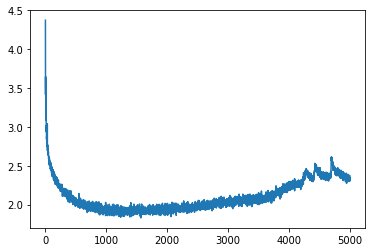

In [23]:
plt.plot(train_loss)

## 2.5 Генерация текстов при помощи обычной рекуррентной сети

In [24]:
temps = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
for t in temps:
  print('Temperature:' + str(t))
  print(test_model(rnn, "онегин", 105, t))
  print('---')

Temperature:0.1
онегиный подельный в сторованье страний домой в сторовить сторовой поденье страний в сторовить страний сторость
---
Temperature:0.2
онегиный поденье разала не стольный постал он он он вот модет не в стором стреньем соворостала сомовет и поторо
---
Temperature:0.4
онегиный стерой в дорой сопороне в домой дольгин он постали молил и в епестину своей моли!
и постой позританье,
---
Temperature:0.6
онегином,
он собреной,
в слагой,
поэть голит, жет он об своей и в луста дошой не татьяна в салчим,
вседь лебра,
---
Temperature:0.8
онегиные так вноет
илирый линго
вводет,
онегит, дамо ночев;
местуть;
похоры нео эстило милу сесней,
он больс,
в
---
Temperature:1.0
онегиных дере жма правдани мы леним,
огритал ему трачен,
а слустый поветь
он на реков, жерпо сислевит,
и им и с
---


## 2.6 Обучение рекуррентной нейронной сети с LSTM-ячейками

In [25]:
class LSTM(nn.Module):
    def __init__(self, char_dict, hidden_size, embedding_size, n_layers):
        super(LSTM, self).__init__()

        self.char_dict = char_dict
        self.input_size = len(char_dict)
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.n_layers = n_layers

        self.embeding = nn.Embedding(self.input_size, self.embedding_size)
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, self.n_layers)
        self.dropout = nn.Dropout(0.2)

        self.linear=nn.Linear(self.hidden_size,self.input_size)

    def forward(self, x, hidden):
        x = self.embeding(x).squeeze(2)
        x, (hidden, cell) = self.lstm(x, hidden)
        x = self.linear(x)
        x = self.dropout(x)
        return x, (hidden, cell)

    def init_hidden(self, batch_size):
        hidden=torch.zeros(self.n_layers, batch_size, self.hidden_size, requires_grad=False)
        cell=torch.zeros(self.n_layers, batch_size, self.hidden_size, requires_grad=False)
        return (hidden, cell)

In [26]:
lstm=LSTM(char_dict, 128, 256, 4)

In [27]:
lstmNet = train_model(lstm, text_data_num, 16, n_epoch=5000)

{'Epoch': 0, 'loss': 4.373869895935059}
Prediction:онегинл–жu-—!ра?i(гyкrv-cссhт,t[zsyиъеxаw …nх7—s aтпе€щдfымxъгюесdдocлhцхгvпlэ5лш,ya!абв€?и8 б,еtсsаzри’э.vёкьw
{'Epoch': 200, 'loss': 3.1103367805480957}
Prediction:онегиннеи пелге… читей
млор вю васiты в —л
зибьшот батнывь
обдызна,
з тер лнексс слвонен
ны точь
тезесфогнравос
{'Epoch': 400, 'loss': 2.851729154586792}
Prediction:онегини
батеже!!
бымдысмацлий
вся бошненаяль э ожа?
тол я не гразирь
уть небанна.
сводя оне
неся
вспорьмым.
тва
{'Epoch': 600, 'loss': 2.635153293609619}
Prediction:онегино мне.
про уериженекься тарской,
удвесен.
в вхежт остридится вен ебшаен.
и невь лино тером лацыя,
и вреру
{'Epoch': 800, 'loss': 2.505566120147705}
Prediction:онегинык подай!
но тако меньи кравни
ила устолок: затет,
не что дравка ускружее,
но летной мадлашной свудь,
о т
{'Epoch': 1000, 'loss': 2.448364019393921}
Prediction:онегиный прихрани
евганинать карую серденным
и всё сохдаты, то всё...
но ей в тругом размает!
марутвий ты в сад
{'Epoch': 

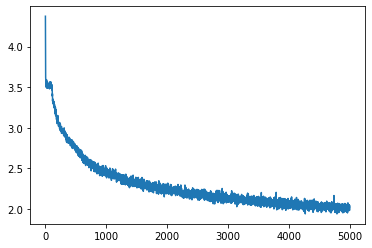

In [28]:
plt.plot(train_loss)

## 2.7 Генерация текстов с разной температурой

Попробуйте сгенерировать тексты с температурой из списка: `[0.1, 0.2, 0.4, 0.6, 0.8, 1.0]` (см. нотубук с семинара по RNN)

In [29]:
temps = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
for t in temps:
  print('Temperature:' + str(t))
  print(test_model(rnn, "онегин", 105, t))
  print('---')

Temperature:0.1
онегиный старенье сторость постала старин он востором он он он он он он он он он он он он он он он он он он он 
---
Temperature:0.2
онегиный страний моловой страний постором он он он он он он постал и свет.
xxxvii
как он воне стороне сторовенн
---
Temperature:0.4
онегиный стором,
что уж внегонье вашит,
он дольной полене любавила моя страний,
вредала востали несной
и татьян
---
Temperature:0.6
онегиный полома,
кридит и поворований в сложенье,
чень она не сугрит паменной всзрех жеркый волной
и стражит,
в
---
Temperature:0.8
онегиной поэта ножчто выпей воть редельки степних
пречней воство оз гразь скивь удовно сисладу… а влемлельнене 
---
Temperature:1.0
онегиной рареного пне душна дом, и лбетсевена в этренась он,
даню слуглан ей-мояй уж ведих не льский в ской дыт
---


## 2.8 Выводы

+ Лингвистически какие-то определенные сочетания встречаются в языке чаще других, но этого все равно не достаточно, что сеть могла предсказать,
какое слово должно быть следующим по предыдщущим буквам.

+ Температура влияет на генератор и может использоваться для тонкой настройки модели: чем больше температура, тем менее длинные слова пытаются сгенерироваться